 # Duality (working title)

* Duality is a proof-of-concept for generic asset modeling in Python (work-in-progress
* It is based on ideas and previous work from my last job
* Explicit intent is to identify whether some of those concepts could be extended more broadly
    * Are these ideas interesting to anyone?
    * Is there any opportunity or are there use cases where this could help via more integration with PyData ecosystem?
    * Does anyone know if anything like this already exists?

## Now, I'm going to try not to look like this
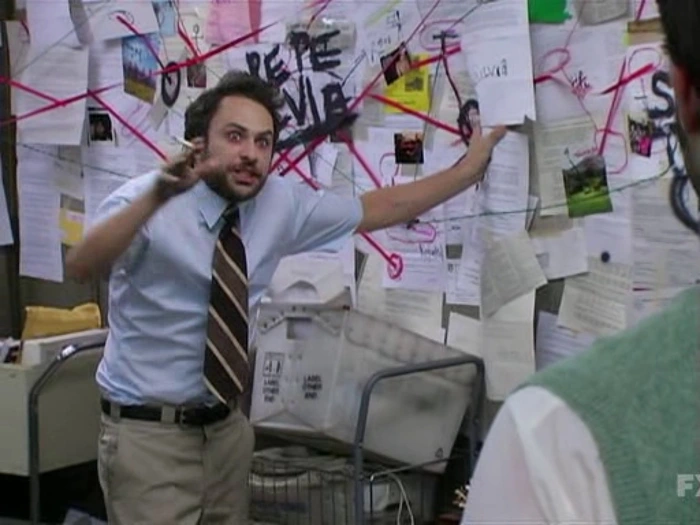

## But I'll warn you, the thing looks sort of like this:

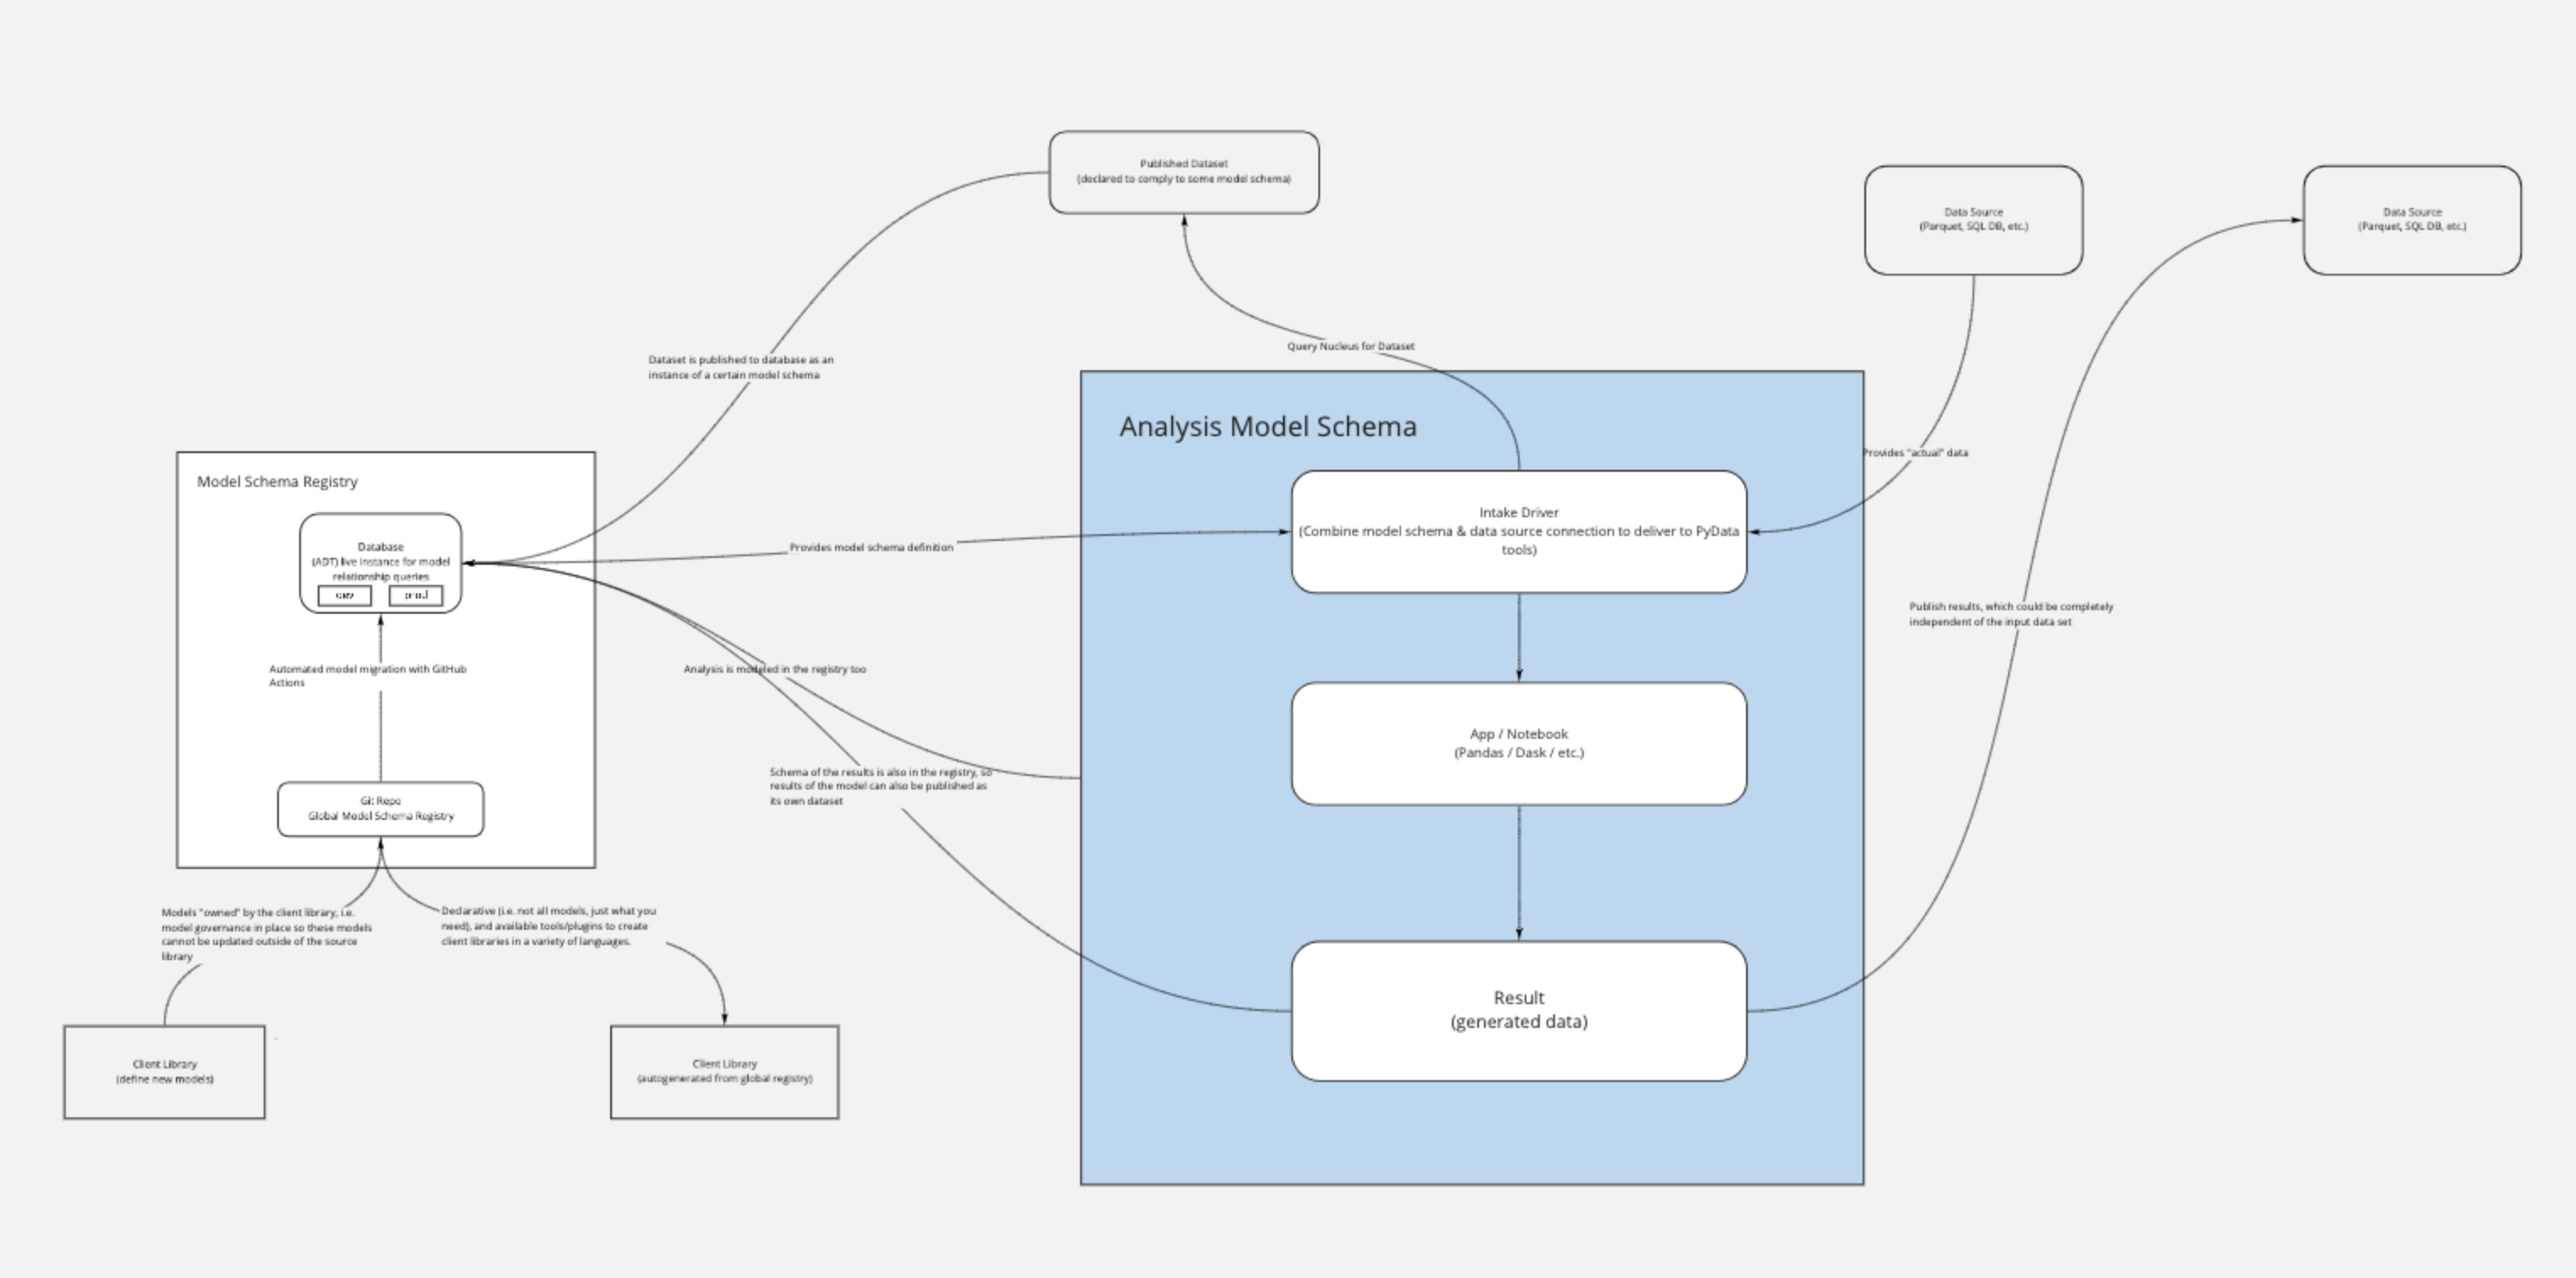

## Duality: High-level Concept

Is it possible to provide a general way for modeling data ontologies, with the following requirements?:

1. UX is simple and can be used/understood by data scientists, engineers, etc.
2. Model schemas can describe real-world things, processes, data sets, etc.
3. Model schemas are stored in a registry
    * Robust versioning and ownership/governance (immutable?)
4. Instances of models are stored in a database/web service
    * Marketplace of models, data, etc.
    * Small data and metadata
    * Graph-based, so relationships can be used to find things easily
5. Actual data sets, models, etc. are stored separately, but users can find/interact with them via the registry
    * e.g. Data set could be registered, and the data set could be accessed via an Intake driver, actual permissions to the resource handled separately

## Existing work

* In the past, I personally build something like the above, but at much smaller scale and for single discipline
* In the later part of my career, we started using Azure Digital Twins for part of the above
* Microsoft also has something called Common Data Model (CDM) which is sort of similar
* Bits are open source, but don't have good integration with PyData (but do with Azure services like data lake, PowerBI, etc.)

## That is a bit hand-wavy! Show me a real use-case!

Below is a floating wind turbine. These are complex, and require modeling of:
* Aerodynamics
* Structural dynamics
* Hydrodynamics
* Electrical/servo modeling

<img src="./openfastlogo.jpeg" alt="Drawing" style="width: 400px; float: center"/>

### Anyone interested in the physics should check out [OpenFAST](https://openfast.readthedocs.io/en/main/)
* A set of time-domain numerical analysis tools developed by National Renewable Energy Laboratory (NREL)
* Open-sourced in 2017
* Written in Fortran (2003)
* Packaged and [available in conda-forge](https://anaconda.org/conda-forge/openfast/)!



### The types of problems we may want to use this tool for:

* Design: Simulate a whole bunch of expected environments, make sure it meets strength & fatigue requirements, produce power production estimates for financial modeling
* Operation: Feed the **same** models with real-time weather forecast datasets or sensor data to forecast response, or optimize production

Challenges:

* How do we do that, while also maintaining the models throughout their lifecycle?
* How do we version changes, and allow different disciplines to interface with each other?
    * Engineering
    * Operations
    * Finance
    * ...
    

### Enough already, what is Duality? First, let's define some models.

In [1]:
from rich import print

from duality.models import BaseModel
from duality.models import Relationship

In [2]:
class Asset(BaseModel, model_prefix="duality:assets", model_version=1):
    name: str
        

class Blade(Asset, model_prefix="duality:assets", model_version=1):
    length: float
    chord: float
    taper: float
        
        
class FloatingWindTurbine(Asset, model_prefix="duality:assets", model_version=1):
    nacelle_height: float
    num_blades: int
    blades: Blade = Relationship()

### An aside: Digital Twins Definition Language ([DTDL](https://github.com/Azure/opendigitaltwins-dtdl/))

This is an open schema Microsoft has developed that lets you describe models with:
* Properties
* Sub-components
* Inheritance
* Relationships

Primarily designed for real-time streaming, but the language is very flexible and available to test with

In [3]:
print(FloatingWindTurbine.to_dict())

{
    '@id': 'dtmi:duality:assets:floating_wind_turbine;1',
    '@type': 'Interface',
    '@context': 'dtmi:dtdl:context;2',
    'comment': '',
    'contents': [
        {'@type': 'Property', 'name': 'nacelle_height', 'schema': 'double'},
        {'@type': 'Property', 'name': 'num_blades', 'schema': 'integer'},
        {
            '@type': 'Relationship',
            'name': 'blades',
            'target': 'dtmi:duality:assets:blade;1'
        }
    ],
    'description': '',
    'displayName': 'FloatingWindTurbine',
    'extends': 'dtmi:duality:assets:asset;1',
    'schemas': []
}

### We are not limited to modeling physical assets. We can also model datasets and computational models!

In [11]:
class EnvironmentalForecastDataset(BaseModel, model_prefix="nhc:datasets", model_version=1):
    """Core metadata that could allow pulling the correct data for the platform's location from NHC database."""
    name: str
    location: str
        

class OpenFASTModel(BaseModel, model_prefix="nrel:models", model_version=1):
    case_number: int
    floating_turbine: FloatingWindTurbine = Relationship()
    environmental_data: EnvironmentalForecastDataset = Relationship()
    results: "OpenFASTSimulationResults" = Relationship()
    

class OpenFASTSimulationResults(BaseModel, model_prefix="nrel:models:results", model_version=1):
    max_stress_in_blade: float
    fatigue: float
    ...
    

OpenFASTModel.update_forward_refs()


def run_openfast_model(input_model: OpenFASTModel) -> OpenFASTSimulationResults:
    """This function will build a model, run the program, post-process, and post the results somewhere."""
    ...

### Now, let's upload these models to Azure Digital Twins!

In [12]:
from duality.adt import ADTClient

adt_client = ADTClient()

adt_client.upload_model(Asset)
adt_client.upload_model(Blade)
adt_client.upload_model(FloatingWindTurbine)
adt_client.upload_model(EnvironmentalForecastDataset)
adt_client.upload_model(OpenFASTModel)
adt_client.upload_model(OpenFASTSimulationResults)

### Upload some twins (instances)

In [9]:
# Create a turbine
adt_client.upload_twin(
    FloatingWindTurbine(
        name="My awesome wind turbine",
        nacelle_height=150.0,
        num_blades=3,
    )
)

# Upload each individual blade
for i in range(3):
    adt_client.upload_twin(
        Blade(
            length=100.0,
            chord=5.0,
            taper=0.75,
            name=f"Blade {i}",
        )
    )

### Let's query some instances!

In [10]:
for twin in adt_client.query.of_model(Asset).all():
    print(twin.to_twin_dtdl())

{
    '$metadata': {'$model': 'dtmi:duality:assets:blade;1'},
    'name': 'Blade 0',
    'length': 100.0,
    'chord': 5.0,
    'taper': 0.75
}

{
    '$metadata': {'$model': 'dtmi:duality:assets:blade;1'},
    'name': 'Blade 1',
    'length': 100.0,
    'chord': 5.0,
    'taper': 0.75
}

{
    '$metadata': {'$model': 'dtmi:duality:assets:blade;1'},
    'name': 'Blade 2',
    'length': 100.0,
    'chord': 5.0,
    'taper': 0.75
}

{
    '$metadata': {'$model': 'dtmi:duality:assets:floating_wind_turbine;1'},
    'name': 'My awesome wind turbine',
    'nacelle_height': 150.0,
    'num_blades': 3
}

{
    '$metadata': {'$model': 'dtmi:duality:assets:blade;1'},
    'name': 'Blade 0',
    'length': 100.0,
    'chord': 5.0,
    'taper': 0.75
}

{
    '$metadata': {'$model': 'dtmi:duality:assets:blade;1'},
    'name': 'Blade 1',
    'length': 100.0,
    'chord': 5.0,
    'taper': 0.75
}

{
    '$metadata': {'$model': 'dtmi:duality:assets:blade;1'},
    'name': 'Blade 2',
    'length': 100.0,
    'chord': 5.0,
    'taper': 0.75
}

### Let's see what that looks like

[My Azure Digital Twins Instance](https://explorer.digitaltwins.azure.net/?tid=9e68b87c-3151-4b22-9211-0036a3ece0cb&eid=duality-dev.api.wcus.digitaltwins.azure.net)


### Summary

The example above is a very small start. The goal is to provide model versioning and governance for numerical models, and make it easier for different disciplines and domains to interact, leveraging standard data types, automation, etc.

Allows domain experts who know Python to:
* Develop and maintain their own numerical models
    * Model marketplace?
* Pull in "real" data, leveraging metadata to more consistently label columns from data sources
    * Data marketplace?
* View numerical model versioning like we're viewing ML model lifecycle management
* Potentially feasible to truly help abstract some of the devops/IT stuff to get out of the way for the domain experts
    * Blueprints?

### Future plans:

* Store models in git for versioning & governance
* Models deployed to ADT runtime with GitHub Actions
* Different backends?
* Integrate with real datasets, storing metadata in graph
* Play with [OpenFAST](https://openfast.readthedocs.io/en/main/) and solve a "real" problem by writing wrapper which uses duality for modeling language

In [10]:
for twin in adt_client.query.all():
    try:
        adt_client.delete_twin(twin)
    except Exception:
        pass

for model in [
    FloatingWindTurbine, 
    Blade, 
    Asset, 
    EnvironmentalForecastDataset, 
    OpenFASTModel, 
    OpenFASTSimulationResults
]:
    adt_client.delete_model(model)
